In [ ]:
# https://drive.google.com/file/d/1DqEhlRlV17G493_4pXl5W7l4ezx1R2Zq/view?usp=sharing
import gdown
file_id = '1DqEhlRlV17G493_4pXl5W7l4ezx1R2Zq'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'images.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1DqEhlRlV17G493_4pXl5W7l4ezx1R2Zq
From (redirected): https://drive.google.com/uc?id=1DqEhlRlV17G493_4pXl5W7l4ezx1R2Zq&confirm=t&uuid=58ba7eb9-1513-4d36-8dcc-d042545cb4d9
To: /content/images.zip
100%|██████████| 698M/698M [00:10<00:00, 66.0MB/s]


'images.zip'

In [ ]:
!unzip images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: 이미지QA/image/train/train_068776.jpg  
  inflating: 이미지QA/image/train/train_068780.jpg  
  inflating: 이미지QA/image/train/train_068806.jpg  
  inflating: 이미지QA/image/train/train_068808.jpg  
  inflating: 이미지QA/image/train/train_068822.jpg  
  inflating: 이미지QA/image/train/train_068823.jpg  
  inflating: 이미지QA/image/train/train_068833.jpg  
  inflating: 이미지QA/image/train/train_068835.jpg  
  inflating: 이미지QA/image/train/train_068854.jpg  
  inflating: 이미지QA/image/train/train_068856.jpg  
  inflating: 이미지QA/image/train/train_068860.jpg  
  inflating: 이미지QA/image/train/train_068869.jpg  
  inflating: 이미지QA/image/train/train_068883.jpg  
  inflating: 이미지QA/image/train/train_068884.jpg  
  inflating: 이미지QA/image/train/train_068887.jpg  
  inflating: 이미지QA/image/train/train_068900.jpg  
  inflating: 이미지QA/image/train/train_068912.jpg  
  inflating: 이미지QA/image/train/train_068923.jpg  
  inflating: 이미지QA/image/train/train_068948.jpg  
  inflating: 이

In [ ]:
from glob import glob
imgs = glob('이미지QA/image/train/*.jpg')
len(imgs)

14077

In [ ]:
import pandas as pd
df = pd.read_csv('/content/이미지QA/train.csv')
len(df)

359521

In [ ]:
sorted(imgs)[0],sorted(imgs)[-1],sorted(imgs)[:5]

('이미지QA/image/train/train_000004.jpg',
 '이미지QA/image/train/train_107225.jpg',
 ['이미지QA/image/train/train_000004.jpg',
  '이미지QA/image/train/train_000007.jpg',
  '이미지QA/image/train/train_000010.jpg',
  '이미지QA/image/train/train_000023.jpg',
  '이미지QA/image/train/train_000024.jpg'])

In [ ]:
df.head()

,ID,image_id,question,answer
0,TRAIN_000000,train_000000,Is this in the wild or zoo?,zoo
1,TRAIN_000001,train_000001,Is this car a recent model?,yes
2,TRAIN_000002,train_000002,Is the man being safe?,yes
3,TRAIN_000003,train_000003,What are the walls made from?,drywall
4,TRAIN_000004,train_000004,How many players are sitting on the bench?,8


In [ ]:
# 이미지 아이디
real_filenames = [ img.split('/')[-1].split('.')[0] for img in sorted(imgs)]
df = df[df['image_id'].isin(real_filenames)].reset_index(drop=True)
df.drop_duplicates(inplace=True)
df[df['image_id'] == 'train_002746']

,ID,image_id,question,answer
373,TRAIN_002814,train_002746,Is this a car-free zone?,no
826,TRAIN_006439,train_002746,What time does the clock on the pole show?,10:20
866,TRAIN_006765,train_002746,How many stories are in the center building?,3
1466,TRAIN_011410,train_002746,What is the name of this building?,clock tower
1618,TRAIN_012636,train_002746,Is it daytime or nighttime?,daytime
...,...,...,...,...
45255,TRAIN_343541,train_002746,Is this sign in a big city?,no
45950,TRAIN_348556,train_002746,Are the streets crowded?,no
46049,TRAIN_349292,train_002746,Is this a real street?,yes
46173,TRAIN_350249,train_002746,What type of roof structure does the building ...,steeple


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from transformers import GPT2Tokenizer, GPT2Model

In [ ]:
class QADataset(Dataset):
  def __init__(self, df, tokenizer,transform, img_path,train=True):  # 이미지QA/image/train/
    self.df = df
    self.tokenizer = tokenizer
    self.transform = transform
    self.img_path = img_path
    self.train = train

  def __len__(self):
    return len(self.df)
  def __getitem__(self, index):
    row =  self.df.iloc[index]
    img_id = row['image_id']
    img = self.img_path + img_id + '.jpg'
    img = Image.open(img).convert('RGB')

    img = self.transform(img)
    question = self.tokenizer.encode_plus(
        row['question'],
        truncation = True,
        add_special_tokens=True,
        padding='max_length',
        max_length=32,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )
    if self.train:
      answer = self.tokenizer.encode_plus(
          row['answer'],
          truncation = True,
          add_special_tokens=True,
          max_length=32,
          padding='max_length',
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt'
      )
      return {
          'image': img,
          'question': question['input_ids'].squeeze(),
          'answer': answer['input_ids'].squeeze()
      }
    else:
      return {
          'image': img,
          'question': question['input_ids'].squeeze(),
      }


In [ ]:
# 토크나이져 확인
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = GPT2Model.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))
# 데이터 셋확인
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])
]
)
da = QADataset(df,tokenizer,transform,'이미지QA/image/train/')
# print(next(iter(da)))
loader = DataLoader(da, batch_size=8, shuffle=True)
sample = next(iter(loader))
sample['question'].shape, sample['answer'].shape, sample['image'].shape

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


(torch.Size([8, 32]), torch.Size([8, 32]), torch.Size([8, 3, 224, 224]))

In [ ]:
sample =  next(iter(da))
sample['question'], sample['answer']

(tensor([ 2437,   867,  1938,   389,  5586,   319,   262,  7624,    30, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257]),
 tensor([   23, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257]))

In [ ]:
sample['question'].squeeze()

tensor([ 2437,   867,  1938,   389,  5586,   319,   262,  7624,    30, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257])

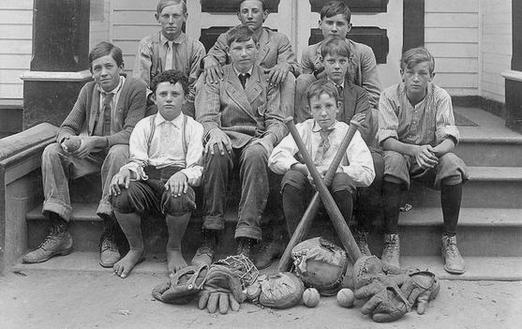

In [ ]:
Image.open('이미지QA/image/train/train_021846.jpg')

In [ ]:
np.array(Image.open('이미지QA/image/train/train_021846.jpg').convert('RGB')).shape

(329, 522, 3)

In [ ]:
# 모델 생성
class QAModel(nn.Module):
    def __init__(self,vocab_size): # 토크나이져의 길이
      super(QAModel, self).__init__()
      self.vocab_size = vocab_size
      self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
      self.gpt2 = GPT2Model.from_pretrained('gpt2')
      self.gpt2.resize_token_embeddings(vocab_size)
      embedding_features_size = 1000+self.gpt2.config.hidden_size  # 이지지넷의 출력크기와 gpt2 출력 크기를 합친 벡터의 사이즈
      self.linear = nn.Linear(embedding_features_size, vocab_size)
    def forward(self,images, question):
      image_features = self.resnet(images)
      image_features = image_features.view(image_features.size(0), -1)  # batch, 1000 --> gpt2와 결합을 위해서
      output = self.gpt2(question)
      output_features = output.last_hidden_state  # 히든레이터의 최종 출력  질문데이터를 입베딩해서 모델의 입력
      image_features = image_features.unsqueeze(1).expand(-1,output_features.size(1), -1)   # 이미지넷에서 추출한 이미지의특성을 질문 토큰의 시퀀스 길이하고 맞게 확장
      combinded = torch.cat([image_features,output_features],dim = -1)  # [batch, squence, 1000+hidden]
      output = self.linear(combinded)
      return output

In [ ]:
# from torchvision.models import resnet50
# resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# gpt2 = GPT2Model.from_pretrained('gpt2')
# gpt2.config.hidden_size

In [ ]:
vocap_size = len(tokenizer)
model = QAModel(vocap_size)
loader = DataLoader(da, batch_size=32, shuffle=True)
next(iter(loader))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


{'image': tensor([[[[-1.0686, -1.0098, -0.9902,  ..., -1.4216, -1.4020, -1.4412],
           [-1.1275, -1.0882, -1.0686,  ..., -1.3627, -1.3627, -1.4020],
           [-1.1471, -1.1078, -1.0882,  ..., -1.3235, -1.3627, -1.3824],
           ...,
           [-1.6569, -1.6373, -1.5000,  ..., -1.6569, -1.6961, -1.6961],
           [-1.6373, -1.5784, -1.4020,  ..., -1.6176, -1.6569, -1.6569],
           [-1.6569, -1.6176, -1.5000,  ..., -1.6176, -1.6961, -1.6961]],
 
          [[-1.0686, -1.0098, -0.9902,  ..., -1.4216, -1.4020, -1.4412],
           [-1.1275, -1.0882, -1.0686,  ..., -1.3627, -1.3627, -1.4020],
           [-1.1471, -1.1078, -1.0882,  ..., -1.3235, -1.3627, -1.3824],
           ...,
           [-1.9706, -2.0098, -1.9510,  ..., -1.6569, -1.6961, -1.6961],
           [-1.9706, -1.9510, -1.8333,  ..., -1.6176, -1.6569, -1.6569],
           [-1.9706, -1.9902, -1.9314,  ..., -1.6176, -1.6961, -1.6961]],
 
          [[-1.1078, -1.0490, -1.0294,  ..., -1.4608, -1.4412, -1.4804],
    

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
from tqdm import tqdm
for epoch in range(1):
  iterator = tqdm(loader)
  for batch in iterator:
    optimizer.zero_grad()
    images = batch['image'].to(device)
    question = batch['question'].to(device)
    answer = batch['answer'].to(device)
    output = model(images,question)
    loss = criterion(output.view(-1,output.size(-1)), answer.view(-1) )  # 평탄화
    loss.backward()
    optimizer.step()
    iterator.set_description(f'epoch: {epoch}, loss: {loss.item()}')

epoch: 0, loss: 0.1461486667394638: 100%|██████████| 1482/1482 [23:14<00:00,  1.06it/s]


In [ ]:
# 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/LLM/model.pt')

In [ ]:
df.head()

,ID,image_id,question,answer
0,TRAIN_000004,train_000004,How many players are sitting on the bench?,8
1,TRAIN_000007,train_000007,What colors are the sheets?,red
2,TRAIN_000010,train_000010,Is the man wearing a hat?,yes
3,TRAIN_000023,train_000023,What is behind the couple?,woman
4,TRAIN_000024,train_000024,What street number is this?,6


In [ ]:
# 추론
device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
# 모델 로드
model = QAModel(vocap_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/LLM/model.pt'))
model.to(device)
model.eval()

# img = Image.open('이미지QA/image/train/train_021846.jpg').convert('RGB')
# 'question' : 'How many people are in the picture?'
testdataset = QADataset(df,tokenizer,transform,'이미지QA/image/train/',train=False)
loader = DataLoader(testdataset, batch_size=1, shuffle=True)

for idx ,batch in enumerate(loader):
  if idx == 10:
    with torch.no_grad():
      images = batch['image'].to(device)
      question = batch['question'].to(device)

      print( ''.join([tokenizer.decode(i.item()) for i in question.squeeze() if i.item() != 50257]) )
      output = model(images,question)
      pred = torch.argmax(output,dim=-1)
      pred = ''.join([tokenizer.decode(i.item()) for i in pred.squeeze() if i.item() != 50257])
      print(pred)
      break

<ipython-input-96-041f0d4efabf>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/LLM/model.pt'))


Where is the cat?
on


In [ ]:
df.iloc[10]['answer']

'yes'

# LLM 을 연동한 내외부 문서 기반 질의 응답 시스템

# Langchain & RAG & LLM(openai 파인튜닝 모델을 로드)
- 데이터(csv)
- langchain형식으로 데이터를 변환
- 데이터 적절히 벡터화
- RAG 데이터베이스에 저장(Chroma 등등)
- 사용자 질문을 Chroma에서 유사 문서를 검색
- 검색된 문서를 LLM 모델에 전달해서 응답생성
- 사용자 인터페이스(옵션)

In [ ]:
!pip install pdfplumber -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 69.1 MB/s eta 0:00:00


In [ ]:
!pip install langchain_community -q
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 17.2 MB/s eta 0:00:00


# pdf 파일 로드

In [ ]:
path_car = '/content/drive/MyDrive/data/car.pdf'
import pdfplumber
with pdfplumber.open(path_car) as pdf:
  data = []
  for page in pdf.pages:
    for idx, page in enumerate(pdf.pages):
      text = page.extract_text()
      data.append({
          'page_number': idx,
          'text': text
      })

In [ ]:
# 필요시 저장
import pandas as pd
df = pd.DataFrame(data)
df = df[df['text'].apply(lambda x: True if len(x) >0 else False)].reset_index(drop=True)
df.to_csv('car.csv',index=False)
data = pd.read_csv('car.csv')
data.head()

In [ ]:
from langchain_community.document_loaders import PDFPlumberLoader
loader = PDFPlumberLoader(path_car)
data = loader.load()

In [ ]:
data[0].page_content

'기아 가족이 되신 것을 진심으로 환영합니다.\n본 사용 설명서에는 차량을 보다 안전하고 쾌적하게 운행할 수 있도록 올바른 사용 방법을 설명하\n였습니다.\n본 사용 설명서에 기재된 이외의 방법으로 차량을 운행할 경우 안전을 보증할 수 없습니다.\n만약 차량 사용 방법 미숙지로 오조작하는 경우 고장 및 사고의 원인이 될 수 있으므로 차량을\n운행하기 전에 반드시 숙지하십시오.\n차량을 최적의 성능으로 유지하려면 자사에서 추천하는 차량 점검 주기에 따라 점검정비를 하십\n시오.\n차량의 올바른 운행을 위해 다음 사항을 참조하십시오.\n1. 본 사용 설명서에 수록된 사양 및 제원은 설계 변경에 따라 사전 통보 없이 변경될 수도 있으\n므로 양해하시기 바랍니다.\n2. 사용 설명서가 손상되지 않도록 사용이 편리한 곳에 보관하시고 필요시에 참고하십시오.\n또한 차량을 타인에게 양도할 때는 본 사용 설명서를 차량과 함께 양도하십시오.\n3. 운행 중에 차량의 이상이나 고장이 발생한 경우 자사 직영 서비스센터 또는 서비스협력사에\n문의하시기 바랍니다.\n4. 차량 개조는 차량의 성능과 안전 및 내구성에 악영향을 줄 수 있으므로 개조하지 마십시오.\n5. 품질이나 성능이 부적합한 부품(특히 변속기 오일 등)을 사용하거나, 불량 연료를 사용했을\n때는 차량에 손상을 줄 수 있습니다. 순정부품(순정오일)은 품질과 성능을 자사가 보증하는\n부품(오일)입니다.\n© 2022 기아 주식회사\n본 책자 내용의 일부 혹은 전체를 사전 서면동의 없이 무단으로 인쇄, 복사, 기록 등의 방법을 이용\n하여, 어떠한 형태로도 복제, 재생, 배포하는 것을 금합니다.\n'

# 벡터화 -> Chroma 에 저장

In [ ]:
!pip install chromadb -q

In [ ]:
# 허깅페이스에 있는 임베딩 모델선택
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
# 허깅페이스 임베딩 모델
model_name = 'jhgan/ko-sroberta-nli'
embedding_model = HuggingFaceEmbeddings(model_name=model_name)
# 데이터 베이스 초기화
vertor_db = Chroma(persist_directory='car_db', embedding_function=embedding_model)
# 데이터 추가
for row in data:
  if isinstance(row.page_content,str):
    vertor_db.add_texts(
        texts=[row.page_content],
        metadatas=[{'page': row.metadata['page']}],
        ids=[f"page_{row.metadata['page']}"]
        )


In [ ]:
# 저장 - commit 과 의미가 비슷?
vertor_db.persist()

In [ ]:
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

import os
os.environ["OPENAI_API_KEY"] = ''

# 데이터 베이스에서 검색 리트리버 생성
retriver = vertor_db.as_retriever()
# openAI LLM 설정

llm = OpenAI(temperature=0.5,
            #  model_name='text-davinci-003',
            #  max_tokens=256,
            #  openai_api_key=''
             )



# 질의 응답 체인 생성
chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriver)

In [ ]:
query = '타이어 위치 교환'
answer = chain.run(query)
print(answer)

 타이어의 위치를 교환하려면 정기적으로 타이어의 마모를 점검하고 교환하십시오. 이때 이상마모가 발생한 타이어는 교환해야 합니다. 또한, 타이어의 균형과 공기압을 정기적으로 점검하고 조정하십시오. 균형과 공기압이 적절하지 않으면 타이어가 완전 마모되거나 잘못 조립된 경우에는 교체해야 합니다. 비상시에는 응급 조치를 취하고 타이어를 교체하십시오.


In [ ]:
# 데이터 베이스 불러오기
vertor_db_loaded = Chroma(persist_directory='car_db', embedding_function=embedding_model)
retriver2 = vertor_db_loaded.as_retriever()
chain2 = RetrievalQA.from_chain_type(llm=llm, retriever=retriver2)
query = '타이어 위치 교환'
answer = chain2.run(query)
print(answer)

 정기적으로 타이어의 위치를 교환하는 것은 타이어의 편마모를 방지하기 위한 중요한 절차입니다. 타이어가 균일하게 마모되면 트레드부에 이상마모가 발생할 수 있으며 이는 타이어의 성능을 저하시키고 사고를 유발할 수 있습니다. 따라서 정기적으로 타이어의 위치를 교환하고 이상마모를 점검하여 필요하다면 타이어를 교체하는 것이 중요합니다. 또한, 타이어의 편마모와 같은 이상 마모 및 차량의 쏠림 현상이 발생했을 때는 즉시 타이어의 균형을 맞추는 것이 중요합니다.
